<a href="https://colab.research.google.com/github/Pakeith0805/SparkPlus_Assignment/blob/staging/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SparkPlusの採用課題です。

- ラベル「0」： airplane（飛行機）
- ラベル「1」： automobile（自動車）
- ラベル「2」： bird（鳥）
- ラベル「3」： cat（猫）
- ラベル「4」： deer（鹿）
- ラベル「5」： dog（犬）
- ラベル「6」： frog（カエル）
- ラベル「7」： horse（馬）
- ラベル「8」： ship（船）
- ラベル「9」： truck（トラック）

# 前処理

In [123]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
import torch.nn.functional as F

In [124]:
# ちゃんとgpuになってるか確認。
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [125]:
# 前処理をまとめる
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # ランダムに左右対称にする
    transforms.ColorJitter(), # ランダムに色を変える。
    transforms.ToTensor(), # 画像をTensorクラスに変えて、チャネルファーストに変えてくれる。
    transforms.Normalize((0.5,), (0.5,)) # 平均、標準偏差を0.5に
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 訓練用データセットと検証用データセットを作成
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
vilidation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_transform)

In [126]:
# データを作る。
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(vilidation_dataset, batch_size=32, shuffle=False)

In [127]:
# CNNを実装。
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2), # RGBなのでin_channelsは3、畳み込むたびに2ずつ画像が小さくなるため、2補う。
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 32×32の画像が16×16になる。
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), # RGBなのでin_channelsは3、畳み込むたびに2ずつ画像が小さくなるため、2補う。
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 16×16の画像が8×8になる。
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1), # RGBなのでin_channelsは3、畳み込むたびに2ずつ画像が小さくなるため、2補う。
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 8×8の画像が4×4になる。
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1), # RGBなのでin_channelsは3、畳み込むたびに2ずつ画像が小さくなるため、2補う。
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Linear(in_features=4 * 4 * 128, out_features=num_classes) # in_featuresには1次元ベクトルにして渡す。4×4が128個ある。out_featuresは何個に分類するか。
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # x.size(0)はバッチ数を表す。(32, 4×4×128)という形になる。
        x = self.classifier(x)
        return x

In [128]:
# modelを作成
model = CNN(10) # 10はクラス数
model.to(device)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
  )
  (classifier): Linear(in_features=2048, out_features=10, bias=True)
)

In [129]:
# 損失関数とoptimizerを設定
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4) # weight_decayで重みづけが大きくなりすぎないようにしている。
# CosineAnnealingWarmRestartsの設定
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=0.)

In [130]:
num_classes=10

In [131]:
# 学習のループ
num_epochs = 15
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs-3):
    total_loss = 0.0 # mixupでは損失の計算方法が異なるため、total_lossに名称変更
    total_acc = 0.0
    y_true = []  # 正解ラベルを保存
    y_pred = []  # 予測ラベルを保存
    for imgs, labels, in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        # こっからmixup
        lmd = np.random.beta(1.0, 1.0)
        idx = torch.randperm(imgs.size(0)).to(device) # ランダムに並び替える
        imgs2 = imgs[idx, :] # 混ぜ合わせる画像
        labels2 = labels[idx]

        labels = F.one_hot(labels, num_classes=num_classes).float()
        labels2 = F.one_hot(labels2, num_classes=num_classes).float()

        # ここまで

        optimizer.zero_grad() # 勾配の初期化
        output = model(lmd * imgs + (1 - lmd) * imgs2) # いじった
        loss = lmd * criterion(output, labels) + (1 - lmd) * criterion(output, labels2) # いじった
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        prob_pred = torch.softmax(output, dim=1)
        total_acc += lmd * torch.mean(pred.eq(labels.argmax(dim=1)).float()) + (1 - lmd) * torch.mean(pred.eq(labels2.argmax(dim=1)).float())
        y_true.extend(labels.cpu().numpy())  # GPU->CPU
        y_pred.extend(pred.cpu().numpy())  # GPU->CPU
    total_loss /= len(train_dataloader)
    total_acc /= len(train_dataloader)
    losses.append(total_loss)
    #accs.append(running_acc)
    accs.append(total_acc.cpu())
    scheduler.step()
#
# validationのループ
#
    val_running_loss = 0.0
    val_running_acc = 0.0
    y_val_true = []  # 正解ラベルを保存
    y_val_pred = []  # 予測ラベルを保存
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())
        # ラベルを保存
        y_val_true.extend(val_labels.cpu().numpy())  # GPU->CPU
        y_val_pred.extend(val_pred.cpu().numpy())  # GPU->CPU

    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    #val_accs.append(val_running_acc)
    val_accs.append(val_running_acc.cpu())
    print("epoch: {}, loss: {}, acc: {}, \
     val loss: {}, val acc: {}".format(epoch, total_loss, total_acc, val_running_loss, val_running_acc))




for epoch in range(num_epochs-12):
    running_loss = 0.0
    running_acc = 0.0
    y_true = []  # 正解ラベルを保存
    y_pred = []  # 予測ラベルを保存
    for imgs, labels, in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() # 位置換えてみた
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        prob_pred = torch.softmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())
        y_true.extend(labels.cpu().numpy())  # GPU->CPU
        y_pred.extend(pred.cpu().numpy())  # GPU->CPU
    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    #accs.append(running_acc)
    accs.append(running_acc.cpu())
    scheduler.step()
#
# validationのループ
#
    val_running_loss = 0.0
    val_running_acc = 0.0
    y_val_true = []  # 正解ラベルを保存
    y_val_pred = []  # 予測ラベルを保存
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())
        # ラベルを保存
        y_val_true.extend(val_labels.cpu().numpy())  # GPU->CPU
        y_val_pred.extend(val_pred.cpu().numpy())  # GPU->CPU

    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    #val_accs.append(val_running_acc)
    val_accs.append(val_running_acc.cpu())
    print("epoch: {}, loss: {}, acc: {}, \
     val loss: {}, val acc: {}".format(epoch+12, running_loss, running_acc, val_running_loss, val_running_acc))

epoch: 0, loss: 1.849244436162142, acc: 0.3464631140232086,      val loss: 1.2026020252285674, val acc: 0.5930511355400085
epoch: 1, loss: 1.5810511461908971, acc: 0.4786299765110016,      val loss: 1.0462343445220315, val acc: 0.648063063621521
epoch: 2, loss: 1.4665448046691587, acc: 0.5297070741653442,      val loss: 0.9168652164669463, val acc: 0.7076677083969116
epoch: 3, loss: 1.3917531353955992, acc: 0.5634894967079163,      val loss: 0.8409880970994504, val acc: 0.7258386611938477
epoch: 4, loss: 1.3375222887736593, acc: 0.5844758152961731,      val loss: 0.7728418030868323, val acc: 0.7578873634338379
epoch: 5, loss: 1.4225202742022578, acc: 0.5510281920433044,      val loss: 0.9077598065042648, val acc: 0.7185503244400024
epoch: 6, loss: 1.3919992183006809, acc: 0.56522136926651,      val loss: 0.8371697719485615, val acc: 0.7377196550369263
epoch: 7, loss: 1.3632946522359426, acc: 0.5766846537590027,      val loss: 0.8114768127663828, val acc: 0.7511980533599854
epoch: 8, lo

In [132]:
labels

tensor([4, 9, 6, 1, 8, 7, 4, 8, 9, 7, 2, 1, 1, 3, 9, 1], device='cuda:0')

In [133]:
one_zero_labels = torch.where(labels == 0, 1, 0)
print(one_zero_labels)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


In [134]:
prob = prob_pred[:, 0]

In [135]:
prob
# probはラベル0の確率。これ使ってroc曲線かける

tensor([1.5765e-03, 8.5769e-04, 1.1613e-05, 4.4827e-03, 4.1475e-03, 3.1141e-01,
        6.7364e-05, 9.2228e-03, 1.3287e-04, 2.5928e-03, 6.1539e-03, 8.2008e-01,
        1.1690e-04, 5.1464e-03, 5.1808e-02, 4.3000e-04], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [136]:
roc = roc_curve(one_zero_labels.cpu().detach().numpy(), prob.cpu().detach().numpy())

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


In [137]:
fpr, tpr, thresholds = roc

print(fpr)
# [0.   0.   0.25 0.25 0.5  0.5  1.  ]

print(tpr)
# [0.   0.25 0.25 0.5  0.5  1.   1.  ]

print(thresholds)
# [1.9 0.9 0.8 0.7 0.6 0.4 0.2]

[0.     0.0625 1.    ]
[nan nan nan]
[          inf 8.2007647e-01 1.1612888e-05]


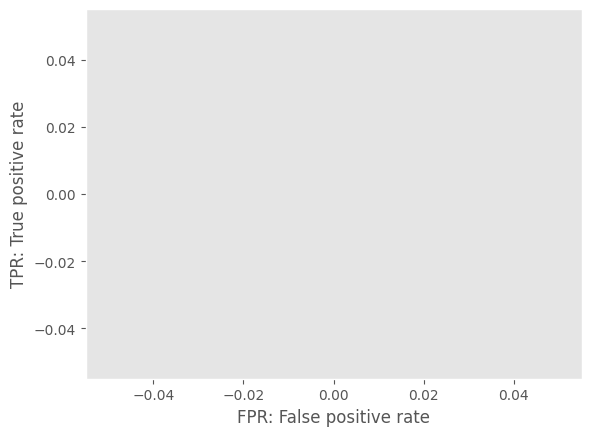

In [138]:
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

# 評価項目

In [139]:
# 正解率
print(accs[-1].cpu())
print(val_accs[-1].cpu())
# 混同行列
cm=confusion_matrix(y_true, y_pred)
val_cm=confusion_matrix(y_val_true, y_val_pred)
print(cm)
print(val_cm)
# 再現率：実際に真だったもののうち、モデルが真と判断した割合。
# 見逃しをなくしたいときに使われる。
# 別名真陽性率。
recall_per_class = cm.diagonal() / cm.sum(axis=1)
val_recall_per_class = val_cm.diagonal() / val_cm.sum(axis=1)
print(recall_per_class)
print(val_recall_per_class)
# 適合率：モデルが真と判断し、実際に真だった割合。猫と判断し、実際に猫だった割合。
# 誤検出をなくしたいときに使われる。
precision_per_class = cm.diagonal() / cm.sum(axis=0)
val_precision_per_class = val_cm.diagonal() / val_cm.sum(axis=0)
print(precision_per_class)
print(val_precision_per_class)
# F1スコア：適合率と再現率の調和平均。
f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class)
val_f1_per_class = 2 * (val_precision_per_class * val_recall_per_class) / (val_precision_per_class + val_recall_per_class)
print(f1_per_class)
print(val_f1_per_class)
# 偽陽性率：実際に偽だったったもののうち、モデルが間違えて真と判断した割合。

tensor(0.8701)
tensor(0.8198)
[[4475   29  132   64   33   21   21   27  125   73]
 [  42 4728   10   15    8    5   11    6   37  138]
 [ 172   15 4035  144  200  146  165   71   37   15]
 [  53   11  178 3747  166  520  166  108   28   23]
 [  50    3  171  160 4291   94   76  136   11    8]
 [  23    5  152  562  141 3899   54  142    9   13]
 [  20   13  124  162   93   41 4513    9   16    9]
 [  29    5   87  126  124  122    9 4474   11   13]
 [ 110   41   29   20   13    5   15   10 4709   48]
 [  82  133   19   30    4   14   19   14   51 4634]]
[[835  13  37  20   8   6   5   7  40  29]
 [ 12 907   4   6   1   3   3   1  16  47]
 [ 37   8 746  47  62  33  40  15   7   5]
 [ 17   3  54 674  47 112  48  24  11  10]
 [ 12   1  47  39 814  21  28  29   9   0]
 [ 13   3  29 139  36 727  18  31   1   3]
 [  6   2  33  49  27   9 871   1   2   0]
 [ 14   1  31  35  32  39   1 838   1   8]
 [ 39  14   7  10   3   3   4   3 901  16]
 [ 18  56   6   8   1   1   2   3  18 887]]
[0.895  

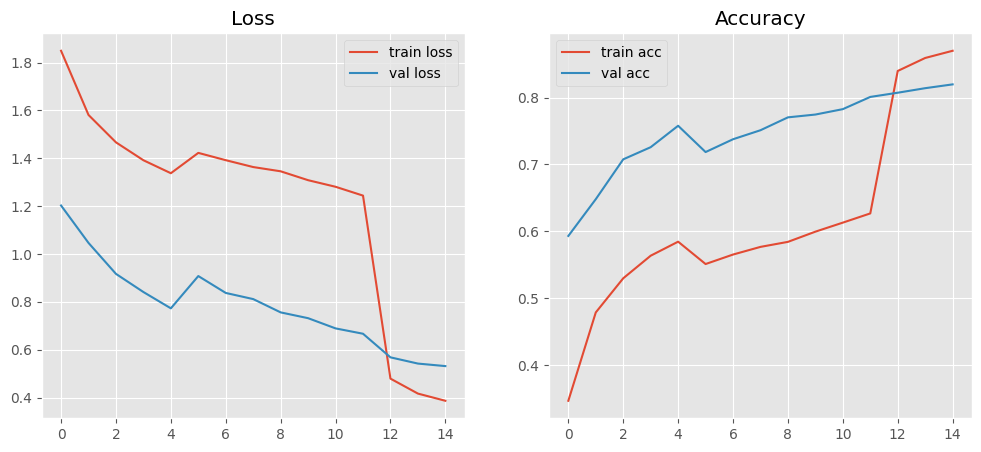

In [140]:
plt.style.use("ggplot")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1行2列のサブプロット

# 左のグラフ(損失)
axes[0].plot(losses, label="train loss")
axes[0].plot(val_losses, label="val loss")
axes[0].legend()
axes[0].set_title("Loss")

# 右のグラフ(精度)
axes[1].plot(accs, label="train acc")
axes[1].plot(val_accs, label="val acc")
axes[1].legend()
axes[1].set_title("Accuracy")

plt.show()

In [141]:
print(accs)
print(val_accs)

[tensor(0.3465), tensor(0.4786), tensor(0.5297), tensor(0.5635), tensor(0.5845), tensor(0.5510), tensor(0.5652), tensor(0.5767), tensor(0.5842), tensor(0.5995), tensor(0.6130), tensor(0.6267), tensor(0.8399), tensor(0.8593), tensor(0.8701)]
[tensor(0.5931), tensor(0.6481), tensor(0.7077), tensor(0.7258), tensor(0.7579), tensor(0.7186), tensor(0.7377), tensor(0.7512), tensor(0.7705), tensor(0.7747), tensor(0.7827), tensor(0.8010), tensor(0.8073), tensor(0.8141), tensor(0.8198)]


In [142]:
# y_val_true はラベル（0 or 1）を含むリスト
y_val_true = torch.tensor(y_val_true)

# val_output に softmax を適用
val_output_tensor = torch.cat([model(val_imgs.to(device)) for val_imgs, _ in validation_dataloader])
val_prob_pred = torch.softmax(val_output_tensor, dim=1)

# クラス0の確率値を取得
prob = val_prob_pred[:, 0].cpu().detach().numpy()

# 0/1 ラベルの取得
one_zero_labels = torch.where(y_val_true == 0, 1, 0).cpu().detach().numpy()

# ROC曲線の計算
fpr, tpr, thresholds = roc_curve(one_zero_labels, prob)

# グラフ描画
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False Positive Rate')
plt.ylabel('TPR: True Positive Rate')
plt.grid()
plt.show()


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 10.12 MiB is free. Process 6024 has 14.73 GiB memory in use. Of the allocated memory 14.52 GiB is allocated by PyTorch, and 74.32 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
def make_roc_curve():
    fig, axes = plt.subplots(5, 2, figsize=(12, 25))  # 5行2列のサブプロット

    for n in range(10):

        # クラス0の確率値を取得
        prob = val_prob_pred[:, n].cpu().detach().numpy()

        # 0/1 ラベルの取得
        one_zero_labels = torch.where(y_val_true == n, 1, 0).cpu().detach().numpy()

        # ROC曲線の計算
        fpr, tpr, thresholds = roc_curve(one_zero_labels, prob)

        # auc算出
        auc_score = roc_auc_score(one_zero_labels, prob)
        print(f"ROC AUC Score: {auc_score:.4f}")

        # 行インデックスと列インデックスの計算
        row_idx = n // 2  # 行インデックス
        col_idx = n % 2   # 列インデックス

        # グラフ描画
        axes[row_idx, col_idx].plot(fpr, tpr, marker='o', color='b', label="ROC Curve")
        axes[row_idx, col_idx].set_xlabel('FPR: False Positive Rate')
        axes[row_idx, col_idx].set_ylabel('TPR: True Positive Rate')
        axes[row_idx, col_idx].set_title(f'ROC Curve - Class {n}')
        axes[row_idx, col_idx].legend()
        axes[row_idx, col_idx].grid()
    plt.tight_layout()
    plt.show()

make_roc_curve()